Will investigate the following 2 reviewer comments here:
(1) Is it possible to optimize the geometry? Or transition states and reaction paths? Perhaps this is the next step, but it would be essential to map out how strong coupling affects chemistry. For the Mg-Br system, is there an effect of the strong coupling on the ground state equilibrium?

(2) Somewhat related to my previous comments on the field strength: The diffference between the simple Jaynes-Cummings-like model (eq. 22) and the CQED-CIS method is very interesting to see, but how strong does the field need to be in order to see these differences. Might it be that for moderate fields, which may be more in line with experiment, in particular for optical cavities, the differences would dissappear?
Still needs to be addressed.



In [1]:
from __future__ import print_function

"""
A script to run the cqed_rhf and cqed_cis method on MgH+ potential energy surface in a cc-pVDZ basis set,
reproducing data from Figure 3 by McTague and Foley.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from matplotlib import pyplot as plt
# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


Methods to fit Pauli-Fierz and Jaynes-Cummings models to CIS data for the ground- and excited-state
of a quantum system (including transition dipole moments in both cases, and the total dipole
moments in the Pauli-Fierz case) given a photon frequency and coupling strength.

In [2]:
# functions for Pauli-Fierz and Jaynes-Cummings model Hamiltonians

def pauli_fierz(e1, e2, omega, lam, mu_g, mu_e, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_mu_g = np.dot(lam, mu_g)
    l_d_mu_e = np.dot(lam, mu_e)
    l_d_tdm  = np.dot(lam, mu_eg)
    
    H[0,0] = e1 + 0.5 * l_d_mu_g ** 2
    H[1,1] = e1 + omega + 0.5 * l_d_mu_g ** 2
    H[2,2] = e2 + 0.5 * l_d_mu_e ** 2
    H[1,2] = np.sqrt(omega/2) * l_d_tdm
    H[2,1] = np.sqrt(omega/2) * l_d_tdm

    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    vecs = vecs[:,idx]
    return vals[0], vals[1], vals[2], vecs

def jaynes_cummings(e1, e2, omega, lam, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_tdm = np.dot(lam, mu_eg)
    H[0,0] = e1 + omega
    H[1,1] = e2
    H[0,1] = np.sqrt(omega/2) * l_d_tdm
    H[1,0] = np.sqrt(omega/2) * l_d_tdm
    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1]


# Quick validation
In the next cell, we will just run a quick test of helper_cis() and helper_cqed_cis() against psi4's CIS.
Note that helper_cis is just ordinary cis but also returns the dipole expectation value of
excited CIS states, which to my knowledge is not available through psi4.
The function helper_cs_cqed_cis() is the cqed-cis method in the coherent state basis.
If the lambda_vector = 0, then all three of these methods should return the same excited-state energies.

In [4]:
mol_str = """
Mg
H 1 1.3
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options and geometry
psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)

om = 0.
lam = np.array([0.,0.,0.])

n_states = 5

# run psi4 SCF
psi4_rhf_e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
# calculate the excited-state energies and save them to a dictionary called 'res'
res = tdscf_excitations(wfn, states=n_states, triplets = "NONE", tda=True)

# parse res for excitation energies
psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]

# run helper_cis()
cis_e, cis_c, cis_mu, tdm = cis(mol_str, options_dict)

# run helper_cs_cqed_cis()
cqed_dict = cs_cqed_cis(lam, om, mol_str, options_dict)

cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
scf_e = cqed_dict['RHF ENERGY']

# collect corresponding excitation energies for comparison
cqed_cis_to_compare = cqed_cis_e[::2]

# check to see that the cis energies match psi4s!
assert( np.isclose(psi4_rhf_e, scf_e))
assert( np.allclose(psi4_excitation_e, cis_e[:n_states]))
assert( np.allclose(psi4_excitation_e, cqed_cis_to_compare[1:n_states+1]))

CL = cqed_dict['CQED-CIS L VECTORS']
CR = cqed_dict['CQED-CIS R VECTORS'] 
CL = cqed_dict['CQED-CIS L VECTORS']
CR = cqed_dict['CQED-CIS R VECTORS'] 

printing eps
[-4.93378214e+01 -4.08104916e+00 -2.60023568e+00 -2.59573445e+00
 -2.59573445e+00 -6.60357641e-01 -2.32876194e-01 -1.47374494e-01
 -1.47374494e-01 -4.53942072e-02 -7.49339147e-03  5.97810350e-02
  5.97810350e-02  1.09321067e-01  1.97047575e-01  1.97047575e-01
  2.09496069e-01  2.09496069e-01  3.61036188e-01  8.93714749e-01
  1.54520555e+00  1.54520555e+00  1.61326052e+00]

Number of occupied orbitals: 6
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862669086
CQED-RHF One-electron energy      = -285.7424508862669086
Nuclear repulsion energy          = 4.8847127138769242
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8574439988287565   dE = -1.99857E+02   dRMS = 1.39184E-08
SCF Iteration   2: Energy = -199.8574439988287565   dE =  0.00000E+00   dRMS = 3.89537E-09
Total time for SCF iterations: 0.004 seconds 

QED-RHF   energy: -199.85744400 hartree
Psi4  SCF energy: -199.85744400 hartree


In [6]:
#print(C_L[0,:])
#print(C_L[1,:])
print(CL[1,1])
print(CR[1,1])

(1+0j)
(1+0j)


# MgH+ Polaritonic Potential Energy Surfaces

For ground-state potential energy surfaces

In [24]:
# template for z-matrix
mol_tmpl = """
Mg
H 1 **R**
symmetry c1
1 1
"""

# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.60, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.70]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])



# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros(len(r_array),dtype=complex)
cqed_rhf_energy_array = np.zeros(len(r_array))
rhf_energy_array = np.zeros(len(r_array))
# electric field strength 
lam_z = 0.0125

# photon energy
om_r = 4.75 / 27.211

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r - 0 * (g_max/2) * 1j

# lambda vector
lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[ctr] = cqed_scf_e+cqed_cis_e[0]
    rhf_energy_array[ctr] = e
    cqed_rhf_energy_array[ctr] = cqed_scf_e
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.033236254686047906

Start SCF iterations:

Canonical RHF One-electron energy = -283.9486473578405139
CQED-RHF One-electron energy      = -283.9489458552046131
Nuclear repulsion energy          = 3.9688290800249999
Dipole energy                     = 0.0007254284632068
SCF Iteration   1: Energy = -199.8973968244046091   dE = -1.99897E+02   dRMS = 1.68280E-05
SCF Iteration   2: Energy = -199.8973972592654604   dE = -4.34861E-07   dRMS = 6.18042E-06
SCF Iteration   3: Energy = -199.8973973125966666   dE = -5.33312E-08   dRMS = 2.37777E-06
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.89739731 hartree
Psi4  SCF energy: -199.89777063 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -283.8986298879413539
CQED-RHF One-electron energy      = -283.8989283889746957
Nuclear repulsion energy          = 3.9441779677267079
Dipole energy                     = 0.0007296933895281
SCF Iteration   1: 

No handles with labels found to put in legend.


cqed_cis 1.6565656565656566
cqed_rhf 1.6565656565656566
rhf 1.6575757575757577
cqed_cis 0.40990764104107075
cqed_rhf 0.41015917496382964
rhf 0.4082864540085504


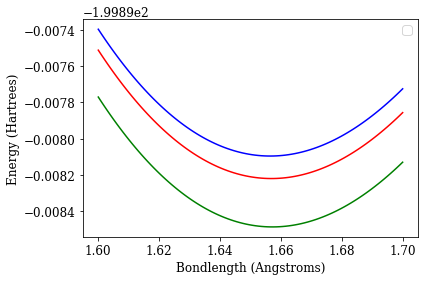

In [26]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline

# fit each surface to a spline
cqed_cis_spline = InterpolatedUnivariateSpline(r_array, np.real(cqed_cis_energy_array), k=3)
cqed_rhf_spline = InterpolatedUnivariateSpline(r_array, np.real(cqed_rhf_energy_array), k=3)
rhf_spline = InterpolatedUnivariateSpline(r_array, np.real(rhf_energy_array), k=3)

# evaluate each spline on a finer grid
r_fine = np.linspace(1.6, 1.7, 100)
cqed_cis_e_fine = cqed_cis_spline(r_fine)
cqed_rhf_e_fine = cqed_rhf_spline(r_fine)
rhf_e_fine = rhf_spline(r_fine)

# get curvatures of each surface
cqed_cis_f = cqed_cis_spline.derivative()
cqed_cis_c = cqed_cis_f.derivative()

cqed_rhf_f = cqed_rhf_spline.derivative()
cqed_rhf_c = cqed_rhf_f.derivative()

rhf_f = rhf_spline.derivative()
rhf_c = rhf_f.derivative()

# get locations of equilibrium geometry
r_eq_cqed_cis = r_fine[np.argmin(cqed_cis_e_fine)]
r_eq_cqed_rhf = r_fine[np.argmin(cqed_rhf_e_fine)]
r_eq_rhf = r_fine[np.argmin(rhf_e_fine)]

# print location of equilibrium bondlength
print("cqed_cis",r_eq_cqed_cis)
print("cqed_rhf",r_eq_cqed_rhf)
print("rhf",r_eq_rhf)

# print curvature evaluated at equilibrium geometries
k_cqed_cis = cqed_cis_c(r_eq_cqed_cis)
k_cqed_rhf = cqed_rhf_c(r_eq_cqed_rhf)
k_rhf = rhf_c(r_eq_rhf)

# print the force constant of each surface in atomic units
print("cqed_cis",k_cqed_cis)
print("cqed_rhf",k_cqed_rhf)
print("rhf",k_rhf)


# plot surfaces on fine grid
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.plot(r_fine, cqed_cis_e_fine, 'red')
plt.plot(r_fine, cqed_rhf_e_fine, 'blue')
plt.plot(r_fine, rhf_e_fine, 'green')
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

In the weak-coupling case, there is a crossing between the the states, and because we are sorting the
eigenvalues in ascending order, we will not see the curve crossing as expected... to do so we must reorder the
arrays that store the jc, pf, and cqed_cis eigenvalues after the bondlength at which the crossing occurs (~2.2 Angstroms, or index 9 of r_array above).  Uncomment and run the block below to do this!

For polaritonic potential energy surfaces

In [28]:
# template for z-matrix
mol_tmpl = """
Mg
H 1 **R**
symmetry c1
1 1
"""

# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.85,1.86,1.87,1.88,1.89,1.90, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, len(r_array)))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,len(r_array)))

# array for ordinary cis
cis_energy_array = np.zeros((5,len(r_array)))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5,len(r_array)),dtype=complex)

# array for model Pauli-Fierz energies
pf = np.zeros((3,len(r_array)),dtype=complex)

# array for Jaynes-Cummings energies
jc = np.zeros((2,len(r_array)),dtype=complex)

# electric field strength 
lam_z = 0.0125

# photon energy
om_r = 4.75 / 27.211

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r 

# lambda vector
lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    #cis_e, cis_c, cis_mu, tdm = cis(molstr, options_dict)
    
    cis_energy_array[0,ctr] = e
    cis_energy_array[0,ctr] = e+psi4_excitation_e[0]
    
    #pf[0,ctr], pf[1,ctr], pf[2,ctr] = pauli_fierz(e, e+cis_e[0], om, lam, cis_mu[:,0], cis_mu[:,1], tdm)
    #jc[0,ctr], jc[1,ctr] = jaynes_cummings(e, e+cis_e[0], om, lam,  tdm)
    
    #assert np.isclose(cis_e[0], psi4_excitation_e[0])
    #assert np.isclose(cis_e[1], psi4_excitation_e[1])
    
    cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.033236254686047906

Start SCF iterations:

Canonical RHF One-electron energy = -282.8388415656265806
CQED-RHF One-electron energy      = -282.8391163177977887
Nuclear repulsion energy          = 3.4325008259675673
Dipole energy                     = 0.0008274548201318
SCF Iteration   1: Energy = -199.8918700532063610   dE = -1.99892E+02   dRMS = 2.00072E-05
SCF Iteration   2: Energy = -199.8918707231253222   dE = -6.69919E-07   dRMS = 7.47140E-06
SCF Iteration   3: Energy = -199.8918708055141167   dE = -8.23888E-08   dRMS = 2.89621E-06
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.89187081 hartree
Psi4  SCF energy: -199.89232977 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -282.7998202794781832
CQED-RHF One-electron energy      = -282.8000930112049218
Nuclear repulsion energy          = 3.4140465204516128
Dipole energy                     = 0.0008313042370298
SCF Iteration   1: 


Start SCF iterations:

Canonical RHF One-electron energy = -282.3587705480425711
CQED-RHF One-electron energy      = -282.3590121233777950
Nuclear repulsion energy          = 3.2071346101212135
Dipole energy                     = 0.0008756974275437
SCF Iteration   1: Energy = -199.8828616902606257   dE = -1.99883E+02   dRMS = 2.18968E-05
SCF Iteration   2: Energy = -199.8828625231348042   dE = -8.32874E-07   dRMS = 8.22328E-06
SCF Iteration   3: Energy = -199.8828626247297109   dE = -1.01595E-07   dRMS = 3.17546E-06
SCF Iteration   4: Energy = -199.8828626395025196   dE = -1.47728E-08   dRMS = 1.22120E-06
Total time for SCF iterations: 0.011 seconds 

QED-RHF   energy: -199.88286264 hartree
Psi4  SCF energy: -199.88337751 hartree


Plot the polaritonic surfaces from the different levels of theory against the CIS electronic surfaces.

cqed_cis 1.8893939393939394
cis 1.9235353535353537
cqed_cis 1.8893939393939394
rhf 1.934040404040404
cqed_cis 0.30470611550316806
cis 0.2262657497827012


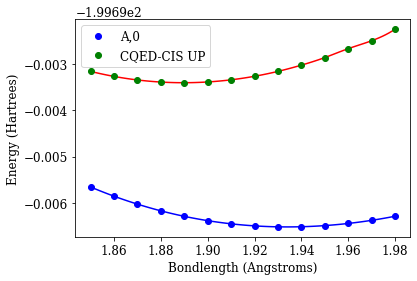

In [29]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams

cqed_cis_spline = InterpolatedUnivariateSpline(r_array, np.real(cqed_cis_energy_array[2,:]), k=3)
cis_spline = InterpolatedUnivariateSpline(r_array, np.real(cis_energy_array[0,:]), k=3)


r_fine = np.linspace(1.85, 1.98, 100)
cqed_cis_e_fine = cqed_cis_spline(r_fine)
cis_e_fine = cis_spline(r_fine)


print("cqed_cis",r_fine[np.argmin(cqed_cis_e_fine)])
print("cis",r_fine[np.argmin(cqed_rhf_e_fine)])

# get curvatures of each surface
cqed_cis_f = cqed_cis_spline.derivative()
cqed_cis_c = cqed_cis_f.derivative()

cis_f = cis_spline.derivative()
cis_c = cis_f.derivative()


# get locations of equilibrium geometry
r_eq_cqed_cis = r_fine[np.argmin(cqed_cis_e_fine)]
r_eq_cis = r_fine[np.argmin(cis_e_fine)]

# print location of equilibrium bondlength
print("cqed_cis",r_eq_cqed_cis)
print("rhf",r_eq_cis)

# print curvature evaluated at equilibrium geometries
k_cqed_cis = cqed_cis_c(r_eq_cqed_cis)
k_cis = cis_c(r_eq_cis)

# print the force constant of each surface in atomic units
print("cqed_cis",k_cqed_cis)
print("cis",k_cis)


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.plot(r_fine, cqed_cis_e_fine, 'red')
plt.plot(r_fine, cis_e_fine, 'blue')
plt.plot(r_array, cis_energy_array[0,:], 'bo', label='A,0')
plt.plot(r_array, np.real(cqed_cis_energy_array[2,:]), 'go', label="CQED-CIS UP")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()






#plt.xlabel("Bondlength (Angstroms)")
#plt.ylabel("Energy (Hartrees)")
#plt.legend()
#plt.show()

Write the data to a file!

In [11]:
# template for z-matrix
mol_tmpl = """
Mg
H 1 2.2
symmetry c1
1 1
"""

molstr = mol_tmpl
n_lam = 10
# electric field strength 
lam_z = np.linspace(0, 0.025, n_lam) 

# set psi4 options
psi4.set_options(options_dict)

# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, n_lam))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,n_lam))

# array for ordinary cis
cis_energy_array = np.zeros((5,n_lam))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5, n_lam),dtype=complex)

# array for model Pauli-Fierz energies
pf = np.zeros((3,n_lam),dtype=complex)

# array for Jaynes-Cummings energies
jc = np.zeros((2,n_lam),dtype=complex)

po = np.zeros((2,n_lam))
#po_pf = np.zeros(n_lam)

# photon energy
om_r = 4.75 / 27.211
gam = om_r/2



#print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r - gam * 1j

# lambda vector
#lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
n_state = 0
ctr = 0
for l in lam_z:
    lam = np.array([0, 0, l])
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    #cis_e, cis_c, cis_mu, tdm = cis(molstr, options_dict)
    
    #cis_energy_array[0,ctr] = e
    #cis_energy_array[0,ctr] = e+psi4_excitation_e[0]
    
    #pf[0,ctr], pf[1,ctr], pf[2,ctr], vecs = pauli_fierz(e, e+cis_e[0], om, lam, cis_mu[:,0], cis_mu[:,1], tdm)
    #jc[0,ctr], jc[1,ctr] = jaynes_cummings(e, e+cis_e[0], om, lam,  tdm)
    #pf_c_g0 = vecs[:,n_state]
    #print(pf_c_g0)
    
    #assert np.isclose(cis_e[0], psi4_excitation_e[0])
    #assert np.isclose(cis_e[1], psi4_excitation_e[1])
    
    cqed_dict_r = cs_cqed_cis(lam, om_r, molstr, options_dict)
    cqed_dict_c = cs_cqed_cis(lam, om, molstr, options_dict)
    Cr_L = cqed_dict_r['CQED-CIS L VECTORS']
    Cc_L = cqed_dict_c['CQED-CIS L VECTORS']
    Cc_R = cqed_dict_c['CQED-CIS R VECTORS']
    real_phot_occ = 0.0 
    complex_phot_occ = 0.0
    for i in range(0, len(Cr_L[:,0])):
        if i%2==1:
            real_phot_occ += np.real(np.conj(Cr_L[i,n_state]) * Cr_L[i,n_state])
            complex_phot_occ += np.real(np.conj(Cc_L[i,n_state]) * Cc_R[i,n_state])
    
    # no loss
    po[0,ctr] = real_phot_occ
    # loss
    po[1,ctr] = complex_phot_occ
    #po_pf[ctr] = np.real(pf_c_g0[1]*np.conj(pf_c_g0[1]))
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    ctr+=1
    

 

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041890924   dE = -1.99864E+02   dRMS = 4.60183E-08
SCF Iteration   2: Energy = -199.8639591041913661   dE = -2.27374E-12   dRMS = 1.41134E-08
Total time for SCF iterations: 0.004 seconds 

QED-RHF   energy: -199.86395910 hartree
Psi4  SCF energy: -199.86395910 hartree
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041890924   dE = -1.99864E+02   dRMS = 4.60183E-08
SCF Iteration   2: Energy = -199.8639591041913661   dE = -2.27374E-12   dR

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6661428449982054
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0016827685361259
SCF Iteration   1: Energy = -199.8628413722369714   dE = -1.99863E+02   dRMS = 4.49638E-05
SCF Iteration   2: Energy = -199.8628450597791186   dE = -3.68754E-06   dRMS = 1.69228E-05
SCF Iteration   3: Energy = -199.8628454966467984   dE = -4.36868E-07   dRMS = 6.39544E-06
SCF Iteration   4: Energy = -199.8628455588644499   dE = -6.22177E-08   dRMS = 2.43559E-06
Total time for SCF iterations: 0.009 seconds 

QED-RHF   energy: -199.86284556 hartree
Psi4  SCF energy: -199.86395910 hartree
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6662386389158996
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.

In [36]:
lam = np.array([0, 0, l])
mol = psi4.geometry(molstr)
e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
# confirm our cis agrees with psi4
res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
# parse res for excitation energies
psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
assert np.isclose(cis_e[0], psi4_excitation_e[0])
assert np.isclose(cis_e[1], psi4_excitation_e[1])
cqed_dict_r = cs_cqed_cis(lam, om_r, molstr, options_dict)
cqed_dict_c = cs_cqed_cis(lam, om, molstr, options_dict)


cqed_cis_e_r = cqed_dict_r['CQED-CIS ENERGY']
cqed_cis_e_c = cqed_dict_c['CQED-CIS ENERGY']

print(cqed_cis_e_r[0:5])
print(cqed_cis_e_c[0:5])



Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6664744393278852
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0037862292062834
SCF Iteration   1: Energy = -199.8614442072973247   dE = -1.99861E+02   dRMS = 1.01153E-04
SCF Iteration   2: Energy = -199.8614627491085685   dE = -1.85418E-05   dRMS = 3.76713E-05
SCF Iteration   3: Energy = -199.8614649046415366   dE = -2.15553E-06   dRMS = 1.41700E-05
SCF Iteration   4: Energy = -199.8614652077042706   dE = -3.03063E-07   dRMS = 5.36938E-06
SCF Iteration   5: Energy = -199.8614652513527119   dE = -4.36484E-08   dRMS = 2.04455E-06
Total time for SCF iterations: 0.013 seconds 

QED-RHF   energy: -199.86146525 hartree
Psi4  SCF energy: -199.86395910 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6664744393278852
Nuclear repulsion energy    

No handles with labels found to put in legend.


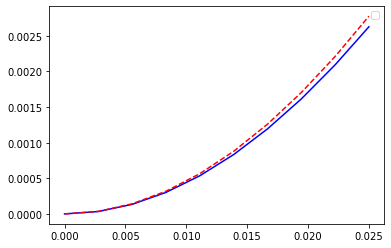

In [12]:


#plt.plot(lam_z, cis_energy_array[0,:]+om, 'red', label='X,1')
#plt.plot(lam_z, cis_energy_array[1,:], 'blue', label='A,0')
####plt.plot(lam_z, np.real(jc[0,:]), 'b--', label="JC LP")
####plt.plot(lam_z, np.real(jc[1,:]), 'g--', label="JC UP")
#plt.plot(lam_z, np.real(pf[1,:]), 'b-*', label="PF LP")
#plt.plot(lam_z, np.real(pf[2,:]), 'g-*', label="PF UP")
####plt.plot(lam_z, np.real(cqed_cis_energy_array[1,:]), 'bo', label="CQED-CIS LP")
####plt.plot(lam_z, np.real(cqed_cis_energy_array[2,:]), 'go', label="CQED-CIS UP")
plt.plot(lam_z, po[0,:], 'blue')
plt.plot(lam_z, po[1,:], 'r--')
plt.legend()
plt.show()

In [ ]:
f = open('MgH_ccpVDZ_Ez_12.5mH_om_4.75_0g.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; JC LP; JC UP; PF LP; PF UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
            np.real(jc[0,ctr]),np.real(jc[1,ctr]), 
            np.real(pf[1,ctr]),np.real(pf[2,ctr]),
            np.real(cqed_cis_energy_array[1,ctr]),np.real(cqed_cis_energy_array[2,ctr])))
    ctr += 1
    
f.close()

Run the cell below to compute the data for Figure 2: scan of ground-state energy
of MgH+ coupled to a photon with energy 4.75 eV and lambda = 0.075 atomic units polarized along z
at the RHF/cc-pVDZ, CQED-RHF/cc-pVDZ, and CQED-CIS/cc-pVDZ levels.

Write the data to a file!

In [ ]:
# plot the ground-state potential energy surfaces
plt.plot(r_array, gs_energy_array[0,:], label='RHF')
plt.plot(r_array, gs_energy_array[1,:], label='CQED-RHF')
plt.plot(r_array, gs_energy_array[2,:], label='CQED-CIS')
plt.legend()
plt.show()


In [ ]:
# write the data to file!
f = open('MgH_gs_lamz_7.5mH_om_4.75.txt', 'w')
stri = "r; rhf_e, cqed_rhf_e, cqed_cis_e"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f \n" % 
            (r, gs_energy_array[0,ctr], gs_energy_array[1,ctr], gs_energy_array[1,ctr]+gs_energy_array[2,ctr]))
    ctr += 1
    
f.close()